# Predicting if Someone Has Alzheimer's

Hello! In this notebook, I'll be predicting whether someone has Alzheimer's or not based on medical data. I'll be comparing multiple analysis methods (Naïve Bayes, logistic regression, support vector machines, and maybe a probabilistic neural network if I get time) to see how they perform and explaining why they are or aren't a good idea for this dataset. For each method, I'll try one version with all data columns included, and one version with multicollinear data columns removed, so I can see how performance changes when we remove multicollinearity.

This notebook will not focus on data exploration, data cleaning, or encoding methods. If you're interested in that, I've covered the basics in [this notebook](https://www.kaggle.com/code/avilashahaldar/housing-prices-with-gradient-boosting-trees).

Let's get started!

In [1]:
import numpy as np
import pandas as pd
import math
import statistics
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import norm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print("Available file:")
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
pd.set_option("future.no_silent_downcasting", True)

Available file:
/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv


In [2]:
def scale_continuous_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    We scale continuous data according to the data description giving the lower and upper bounds.
    """
    data["BMI"] = (data["BMI"] - 15.0) / 25.0
    data["AlcoholConsumption"] = data["AlcoholConsumption"] / 20.0 
    data["PhysicalActivity"] = data["PhysicalActivity"] / 10.0 
    data["DietQuality"] = data["DietQuality"] / 10.0 
    data["SleepQuality"] = (data["SleepQuality"] - 4.0) / 6.0 
    data["SystolicBP"] = (data["SystolicBP"] - 90.0) / 90.0 
    data["DiastolicBP"] = (data["DiastolicBP"] - 60.0) / 60.0 
    data["CholesterolTotal"] = (data["CholesterolTotal"] - 150.0) / 150.0 
    data["CholesterolLDL"] = (data["CholesterolLDL"] - 50.0) / 150.0 
    data["CholesterolHDL"] = (data["CholesterolHDL"] - 20.0) / 80.0
    data["CholesterolTriglycerides"] = (data["CholesterolTriglycerides"] - 50.0) / 350.0 
    data["MMSE"] = data["MMSE"] / 30.0
    data["FunctionalAssessment"] = data["FunctionalAssessment"] / 10.0
    data["ADL"] = data["ADL"] / 10.0
    data["EducationLevel"] = data["EducationLevel"] / 3.0
    data["Age"] = (data["Age"] - 60.0) / 30.0
    
    return data

# Reading in and processing data

First, we remove the ID column because it's not useful in predicting Alzheimer's. It's just an index. We also remove the confidential column at the end because every entry there is censored, so again, no useful info. 

In [3]:
data = pd.read_csv("/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv").drop(columns=["PatientID", "DoctorInCharge"])
data.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


The ethnicity column is given in numbers:

- 0: Caucasian
- 1: African American
- 2: Asian
- 3: Other

But any analysis method we use would assume a meaning to the order of numbers, which isn't true, so we'll one-hot-encode these.

We'll also turn any int columns that are only 1s and 0s into bool columns. This will make it easier to divide the data later into ones we can use Naïve Bayes on, and ones we can use Gaussian Naïve Bayes on. We base these decisions on the [data description](https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset/data).

In [4]:
data["Ethnicity"] = data["Ethnicity"].map(pd.Series({0: "Caucasian", 1: "Black", 2: "Asian", 3: "Other"}))

In [5]:
ethnicity_columns = pd.get_dummies(data["Ethnicity"])
data = pd.concat([data.drop(columns=["Ethnicity"]), ethnicity_columns], axis=1)

In [6]:
int_columns_to_make_bool = ["Gender", "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease",
                           "Diabetes", "Depression", "HeadInjury", "Hypertension", "MemoryComplaints",
                           "BehavioralProblems", "Confusion", "Disorientation", "Diagnosis",
                           "PersonalityChanges", "DifficultyCompletingTasks", "Forgetfulness"] + ethnicity_columns.columns.tolist()

non_bool_columns = list(set(data.columns) - set(int_columns_to_make_bool))

data = pd.concat([data[non_bool_columns], data[int_columns_to_make_bool].astype(bool)], axis=1)
data.head()

,BMI,SleepQuality,Age,CholesterolHDL,DiastolicBP,DietQuality,FunctionalAssessment,CholesterolTotal,MMSE,SystolicBP,...,Confusion,Disorientation,Diagnosis,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Asian,Black,Caucasian,Other
0,22.927749,9.025679,73,33.682563,72,1.347214,6.518877,242.366840,21.463532,142,...,False,False,False,False,True,False,False,False,True,False
1,26.827681,7.151293,89,79.028477,64,0.518767,7.118696,231.162595,20.613267,115,...,False,False,False,False,False,True,False,False,True,False
2,17.795882,9.673574,73,69.772292,116,1.826335,5.895077,284.181858,7.356249,99,...,False,True,False,False,True,False,False,False,False,True
3,33.800817,8.392554,74,68.457491,115,7.435604,8.965106,159.582240,13.991127,118,...,False,False,False,False,False,False,False,False,True,False
4,20.716974,5.597238,89,56.874305,117,0.795498,6.045039,237.602184,13.517609,94,...,False,False,False,True,True,False,False,False,True,False


Since we have 2 classes for the label column (Diagnosis true and Diagnosis false), let's see whether our classes are balanced.

In [7]:
data["Diagnosis"].value_counts()

Diagnosis
False    1389
True      760
Name: count, dtype: int64

Nope, not balanced. That's rather expected, though - this is usually what happens with medical and fraud detection datasets; the class we're interested in is interesting specifically because it's not super common. We've still got enough of the minority class that I don't feel it's vital to consider using **oversampling** or **undersampling** to get more balanced classes (not that I'd want to use undersampling with such little data anyway). I've talked more about these techniques [here](https://www.kaggle.com/code/avilashahaldar/housing-prices-with-gradient-boosting-trees).

Let's start looking at dtypes and checking for NaNs.

In [8]:
data.dtypes

BMI                          float64
SleepQuality                 float64
Age                            int64
CholesterolHDL               float64
DiastolicBP                    int64
DietQuality                  float64
FunctionalAssessment         float64
CholesterolTotal             float64
MMSE                         float64
SystolicBP                     int64
CholesterolTriglycerides     float64
PhysicalActivity             float64
EducationLevel                 int64
ADL                          float64
CholesterolLDL               float64
AlcoholConsumption           float64
Gender                          bool
Smoking                         bool
FamilyHistoryAlzheimers         bool
CardiovascularDisease           bool
Diabetes                        bool
Depression                      bool
HeadInjury                      bool
Hypertension                    bool
MemoryComplaints                bool
BehavioralProblems              bool
Confusion                       bool
D

In [9]:
# Get the total number of NaNs in the dataset
data.isna().sum().sum()

0

Oh wow. That's a pleasant surprise - everything is numerical (no object columns) and there aren't any NaNs. That makes the data processing part a lot easier.

Since this is a prediction task where we already have the answers in the training data, this is a **supervised learning** task, giving us numerous potential models to choose from. I'm thinking of starting with Naïve Bayes (note that we'll use the regular Naïve Bayes for any columns that are only 1s and 0s, as Naïve Bayes checks the probability of a feature existing vs the probability of the label being true; we'll use Gaussian Naïve Bayes for numerical features). My concern with this approach is that all Naïve Bayes methods assume independence of all features, and that is simply not true here.

We could use the variance inflation factor to find the highly multicollinear features and get rid of them, but honestly, I'm rather curious to see how much worse Naïve Bayes will do with non-independent features than other methods like logistic regression or a neural network. Since this isn't a competition, there's more space for me to try different things.

I'm going to try Naïve Bayes twice - once with the data as is, and once with highly multicollinear columns removed, just to see what happens.

# About Naïve Bayes

**Naïve Bayes** is a popular classification method due to its simplicity and non-black-box behavior. It's relatively easy to understand compared to many deep learning frameworks (e.g. transformers, long short-term memory) and also doesn't take as much computation or time to train. It's not a method that I expect to perform well on this data though, and I'll explain why in a bit.

## Bayes Theorem

Naïve Bayes is based on **Bayes Theorem**, which is about conditional probability, and tells you the probability of something being true given that something else is already known to be true. The theorem is given below and assumes that $A$ and $B$ are independent. Note that $P(A|B)$ means probability of $A$ being true if $B$ is true.

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Let's consider $A$ to be a given label classification, and $B$ to be a feature. If we assume complete independence of all features, we can also consider $B$ to indicate multiple features being true, like so:

$$B = B_0 \textrm{ and } B_1 \textrm{ and } ... \textrm{ and } B_n \textrm{ all being true}$$

$$P(A|B_0 \,\textrm{and}\, ... B_n\, \textrm{being true}) = \frac{P(\textrm{all} \,B \,\textrm{features being true} | A) \times P(A)}{P(\textrm{all} \,B \,\textrm{features being true})}$$

Assuming independence of features,

$$P(\textrm{all} \,B \,\textrm{features being true}) = P(B_0) \times P(B_1) \times ... \times P(B_n)$$

We can also set any $B_n$ to be an opposite or a false condition. So we could have $P(B) = P(\textrm{(Smoker) and (no Diabetes)})$.

## Naïve Bayes Types

There are a few different "types" of naïve Bayes used for different data types. The classical **Naïve Bayes** is good for boolean features denoting the existence of something, and we then determine how often the existence of that feature correlates to a certain label value. We've got a lot of bool columns (e.g. Diabetes, which is a boolean telling us if a person has diabetes), so we'll use Naïve Bayes for those.

**Gaussian Naïve Bayes** is for continuous numerical features where we determine the mean and standard deviation of the feature assuming a given label value. We can use the Gaussian distribution from that mean and standard deviation to determine the likelihood when given a new feature value, and use those likelihoods to determine which label value is most likely. This does assume a normal distribution of 

A concern here is that most of our numerical columns aren't actually normally distributed. The data card I linked earlier has frequency plots at the bottom for each feature, and it's quite clear that some numerical features are uniformly distributed. Because of this, I'm expecting logistic regression to work better than Naïve Bayes, but we'll see.

## Calculating Classical Naïve Bayes

I'm going to define my own functions for determining Naïve Bayes rather than using the standard sklearn ones. In a production setting, I'd use the sklearn functions, but just as an exercise, I want to try writing the functions myself. Plus, it helps anyone reading this notebook better understand what Naïve Bayes is actually calculating.

We start by defining the columns we want (the boolean ones) and getting the **prior probabilities**, which are the general probability $P(A)$ of a certain label value occurring, where the label values here are True and False diagnoses of Alzheimer's.

We then get the **conditional probabilities** of a feature being true given a certain label value, $P(B|A)$. We also need the general probabilities of each feature, or the chance of a feature being true regardless of the label value, which is $P(B)$.

In [10]:
def train_classical_naive_bayes(data: pd.DataFrame, label_col: str = "Diagnosis") -> (pd.DataFrame, pd.Series, pd.DataFrame, list):
    """
    This function calculates everything we need to make classical Naive Bayes predictions on boolean columns.
    We calculate prior probabilities, conditional probability, and general feature probabilities.
    """
    X = data.drop(columns=[label_col])
    y = data[label_col]
    
    bool_cols = X.dtypes[X.dtypes == bool].index
    
    unique_label_vals = y.unique()
    prior_probabilities = y.value_counts() / len(y)
    
    # Probabilities for each feature, regardless of label value
    feature_probabilities = X[bool_cols].sum() / len(X)
    feature_probabilities = pd.concat([feature_probabilities, 1-feature_probabilities], axis=1)
    feature_probabilities.columns = [True, False]
    
    # We calculate conditional probabilities for each unique possible class/output
    conditional_probabilities = pd.DataFrame(columns=unique_label_vals.tolist(), index=bool_cols.tolist())
    
    for classification in unique_label_vals:
        this_df = data[data[label_col] == classification].drop(columns=[label_col])
        boolean_probabilities = this_df[bool_cols].sum(axis=0) / len(this_df)
        conditional_probabilities.loc[bool_cols, classification] = boolean_probabilities
    
    # conditional_probabilities currently has the columns [True, False] for the label values
    # and has the probability of each feature column being true given the label value = [conditional_prob column name]
    # So the True column is the probability that each feature is true given the label is True.
    
    # We then create the equivalent dataframe for the probability that each feature is False.
    conditional_probabilities_false = 1-conditional_probabilities
    
    # We then make MultiIndex columns with the first level being the label value and the second level being the feature value.
    conditional_probabilities.columns = pd.MultiIndex.from_tuples(((i, True) for i in conditional_probabilities.columns), names=["LabelValue", "FeatureValue"])
    conditional_probabilities_false.columns = pd.MultiIndex.from_tuples(((i, False) for i in conditional_probabilities_false.columns), names=["LabelValue", "FeatureValue"])

    # We combine the conditional probability dataframes so we now have every combo of [label_val, feature_val].
    conditional_probabilities = pd.concat([conditional_probabilities, conditional_probabilities_false], axis=1)
    
    return conditional_probabilities, prior_probabilities, feature_probabilities, bool_cols

We also need to define how we'll use these values to make new predictions on test_data which does not have the Diagnosis column. 

For classical Naïve Bayes, we will only consider the boolean columns and, for each label value, we get the probability of the feature values being what they are, assuming the label value. This is $P(B|A)$.

We also have $P(A)$ as the total_probabilities and $P(B)$ as the general_probabilities.

One thing we need to be careful about is **underflow**, which is when our values get too close to 0 for our computer to remember the digits correctly. Since we'll be multiplying all the probabilities $P(B_0, B_1, ... B_n)$ together, we could end up with very small values, so we'll be **taking the logs of all probabilities**.

When Naïve Bayes is used for natural language processing (e.g. classifying an email as spam or not), and the probabilities are of the existence of different words, it's important to deal with the case that test data includes words that didn't exist in the training data. This is often done through **Laplace additive smoothing**, or adding a small number to the probabilities of new words to avoid multiplying by 0 probability, or if we're doing log-transforms, then to avoid taking the log of 0.

If any of our conditional probabilities were 0, Laplace smoothing would be necessary. However, we don't have that, and I think it's better to not change the probability values themselves if we don't have to, for accuracy's sake.

In [11]:
def do_naive_bayes_predictions(conditional_probabilities: pd.DataFrame, total_probabilities: pd.Series, feature_probabilities: pd.DataFrame, bool_cols: list, test_data: pd.DataFrame) -> pd.DataFrame:
    """
    Here, we use the outputs from train_classical_naive_bayes to process test data and obtain the probabilities of each row of test data
    corresponding to a certain label value.
    
    We will not actually get the most likely label value for each row of test data because we want to be able to multiply these probabilities
    by Gaussian Naive Bayes probabilities later on.
    """
    test_data = test_data[bool_cols]
    
    # Here, we replace the boolean value in the test data with the corresponding feature probability, take the log, and sum.
    # This is equivalent to multiplying all the probabilities and then taking the log.
    test_general_probabilities = np.log(test_data.copy().replace(feature_probabilities.T.to_dict()).astype(float)).sum(axis=1)
    
    results = pd.DataFrame(index=test_data.index, columns=total_probabilities.index, dtype=float)
    
    for labelval in total_probabilities.index:
        
        # We get the conditional probability of the features being what they are given that the label = labelval
        # So we take the log of all the conditional probabilities and then sum, which is the same as
        # log(P(B0|A) * P(B1|A) * ... P(Bn|A))
        
        this_conditional_probability = np.log(test_data.copy().replace(conditional_probabilities[labelval].T.to_dict()).astype(float))
        
        # We want to multiply P(B|A) by P(A)/P(B). Since we've taken logs, this is just adding and subtracting
        this_conditional_probability = this_conditional_probability.sum(axis=1) + np.log(total_probabilities[labelval]) - test_general_probabilities
        results[labelval] = this_conditional_probability
    
    return results

## Calculating Gaussian Bayes

Let's talk about how Gaussian Naive Bayes works. With Gaussian Naive Bayes, we have continuous data rather than checking for the existence of a feature. We divide the training data according to the label values. In our case, we have 2 possible label values (Diagnosis true and Diagnosis false), so we have 2 dataframes now. For each dataframe and each feature, we fit a Gaussian to the feature values, so we have the probability density function of each feature given a certain label value.

As before, we will also use the training data to estimate the prior probability of each label value. So now we have a Gaussian for each feature, for each label value. Then to make a prediction, we take a row of testing data and look at the Gaussians fitted assuming that label=True. We get the likelihood of each feature on its relevant Gaussian, multiply the likelihoods, and then multiply by the prior probabilities. We then do the same for label=False. If including classical Naive Bayes columns, we'll then multiply by the classical Naive Bayes probabilities as well.

We now have a probability for each label value, and just need to choose the label value with the largest probability. Note that the probabilitie will NOT add to 1.

Let's define our functions for training and testing using Gaussian Naive Bayes.

In [12]:
def train_gaussian_naive_bayes(data: pd.DataFrame, label_col: str="Diagnosis") -> (pd.DataFrame, pd.DataFrame, pd.Series, list):
    """
    Here, we use training data to calculate everything we need to predict on test data with Gaussian Naive Bayes.
    """
    X = data.drop(columns=[label_col])
    y = data[label_col]
    
    gaussian_cols = X.dtypes[X.dtypes != bool].index
    
    unique_label_vals = y.unique()
    prior_probabilities = y.value_counts() / len(y)
    
    all_means = pd.DataFrame(index = gaussian_cols, columns=unique_label_vals, dtype=float)
    all_standard_devs = pd.DataFrame(index = gaussian_cols, columns=unique_label_vals, dtype=float)
    
    all_means.columns.names = ["LabelValue"]
    all_standard_devs.columns.names = ["LabelValue"]
    
    for labelval in unique_label_vals:
        this_df = data[data[label_col] == labelval][gaussian_cols]
        all_means[labelval] = this_df.mean()
        all_standard_devs[labelval] = this_df.std()
        
    return all_means, all_standard_devs, prior_probabilities, gaussian_cols

In [13]:
def do_gaussian_bayes_predictions(all_means: pd.DataFrame, all_standard_devs: pd.DataFrame, total_probabilities: pd.Series, gaussian_cols: list, test_data: pd.DataFrame) -> pd.DataFrame:
    """
    Here, we calculate the probability of each label value for each row of test data using the outputs from train_gaussian_naive_bayes.
    """
    test_data = test_data[gaussian_cols]
    all_gaussian_results = pd.DataFrame(index=test_data.index, columns=total_probabilities.index)
    
    for classification in total_probabilities.index:
        m = all_means[classification]
        s = all_standard_devs[classification]
        
        # Here, we're getting the log likelihood of each test_data value using the means and standard deviations of each columns
        # We then sum across each row, which represents a different patient, since summing the logs
        # is the same as taking the log of the product of all likelihoods
        
        # We also sum the log prior probability to give us log(P(A) * L(B|A)) where L is the likelihood
        log_likelihood = np.sum(np.log(norm.pdf(test_data,m,s)), axis=1) + np.log(total_probabilities[classification])
        all_gaussian_results[classification] = log_likelihood
    
    return all_gaussian_results

Below, I've written some functions to help us analyze our test data results later.

In [14]:
def count_categories(test_predictions: pd.Series, test_answers: pd.Series) -> dict:
    """
    We get the total number of true/false negatives and positives based on the series of predictions, and series of answers.
    We assume boolean predictions.
    """
    all_results = pd.concat([test_predictions, test_answers], axis=1)
    all_results.columns = ["predictions", "answers"]
    
    true_positives = all_results[(all_results["predictions"] == True) & (all_results["answers"] == True)]
    true_negatives = all_results[(all_results["predictions"] == False) & (all_results["answers"] == False)]
    false_positives = all_results[(all_results["predictions"] == True) & (all_results["answers"] == False)]
    false_negatives = all_results[(all_results["predictions"] == False) & (all_results["answers"] == True)]   
    
    return {"TP": len(true_positives), "TN": len(true_negatives), "FP": len(false_positives), "FN": len(false_negatives)}

def make_confusion_matrix(test_predictions: pd.Series, test_answers: pd.Series):
    """
    We plot the confusion matrix.
    """
    all_results = pd.concat([test_predictions, test_answers], axis=1)
    all_results.columns = ["predictions", "answers"]
    
    cm = confusion_matrix(test_answers, test_predictions, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.show()
    plt.close()
    
def make_ROC_curve(test_predictions: pd.Series, test_answers: pd.Series, label: str="") -> float:
    """
    We calculate and print the AUC and plot the ROC curve.
    """
    auc = roc_auc_score(test_answers, test_predictions)
    print(f"Area under ROC curve (AUC): {auc}")
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_answers, test_predictions)
    plt.title('ROC curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], ls="--", label="By Chance")
    plt.legend(bbox_to_anchor = (1, -0.15))
    
    plt.show()
    plt.close()
    
    return auc

Okay, we've defined the functions for calculating Gaussian and Naive Bayes. But before we use them, we need to ask ourselves whether it's actually a good idea to use them here. We mentioned before that it's likely that many of the features are not independent, since they indicate comorbid conditions, so we've already failed that assumption which is necessary for all forms of naive Bayes.

Let's also test the assumption that columns used for Gaussian Naive Bayes are actually Gaussian, by plotting our numerical columns. First we plot for the case where Diagnosis is True.

array([[<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'SleepQuality'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'CholesterolHDL'}>],
       [<Axes: title={'center': 'DiastolicBP'}>,
        <Axes: title={'center': 'DietQuality'}>,
        <Axes: title={'center': 'FunctionalAssessment'}>,
        <Axes: title={'center': 'CholesterolTotal'}>],
       [<Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'SystolicBP'}>,
        <Axes: title={'center': 'CholesterolTriglycerides'}>,
        <Axes: title={'center': 'PhysicalActivity'}>],
       [<Axes: title={'center': 'EducationLevel'}>,
        <Axes: title={'center': 'ADL'}>,
        <Axes: title={'center': 'CholesterolLDL'}>,
        <Axes: title={'center': 'AlcoholConsumption'}>]], dtype=object)

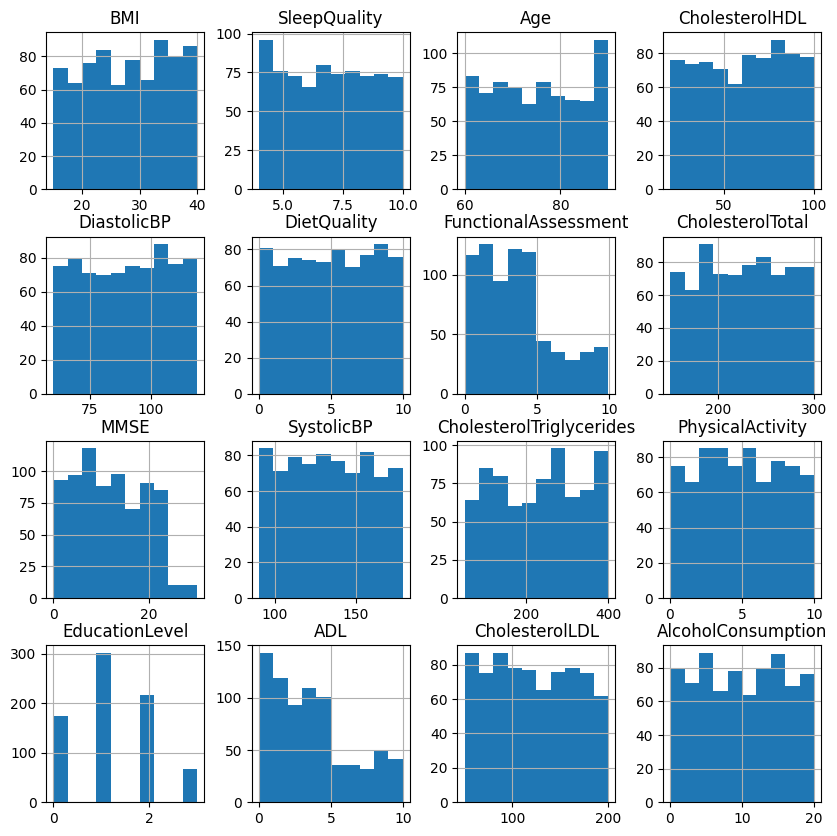

In [15]:
gaussian_cols = data.dtypes[data.dtypes != bool].index
data.loc[data["Diagnosis"] == True][gaussian_cols].hist(figsize=(10,10))

Then we plot for where diagnosis is False.

array([[<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'SleepQuality'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'CholesterolHDL'}>],
       [<Axes: title={'center': 'DiastolicBP'}>,
        <Axes: title={'center': 'DietQuality'}>,
        <Axes: title={'center': 'FunctionalAssessment'}>,
        <Axes: title={'center': 'CholesterolTotal'}>],
       [<Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'SystolicBP'}>,
        <Axes: title={'center': 'CholesterolTriglycerides'}>,
        <Axes: title={'center': 'PhysicalActivity'}>],
       [<Axes: title={'center': 'EducationLevel'}>,
        <Axes: title={'center': 'ADL'}>,
        <Axes: title={'center': 'CholesterolLDL'}>,
        <Axes: title={'center': 'AlcoholConsumption'}>]], dtype=object)

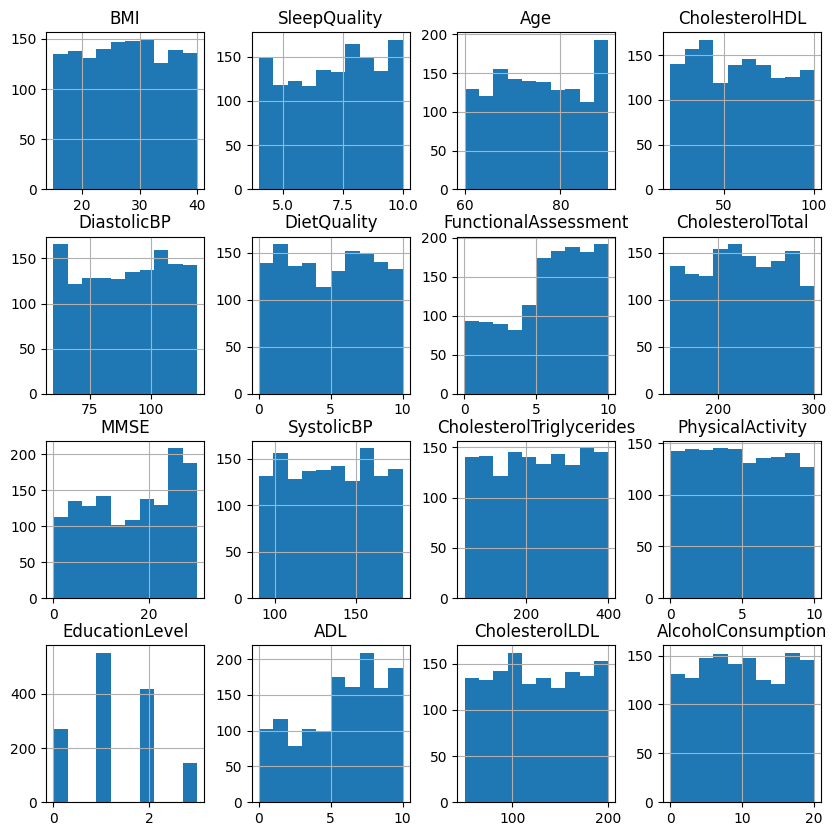

In [16]:
data.loc[data["Diagnosis"] == False][gaussian_cols].hist(figsize=(10,10))

## Why is Nothing Normally Distributed?

Oh boy. Nearly none of these look normally distributed whatsoever. While classical Naïve Bayes does not assume a normal distribution of features, Gaussian Naïve Bayes _does_ assume a normal distribution of features, which is not true for anything here besides EducationLevel. This is the reason why I don't expect Naïve Bayes with both classical and Gaussian naïve Bayes to do well on this data.

I suspect that the reason why everything looks oddly uniform is because **the data has intentionally cut off the tails**. Look at the data description of the clinical measurements:

- SystolicBP: Systolic blood pressure, ranging from 90 to 180 mmHg.
- DiastolicBP: Diastolic blood pressure, ranging from 60 to 120 mmHg.
- CholesterolTotal: Total cholesterol levels, ranging from 150 to 300 mg/dL.
- CholesterolLDL: Low-density lipoprotein cholesterol levels, ranging from 50 to 200 mg/dL.
- CholesterolHDL: High-density lipoprotein cholesterol levels, ranging from 20 to 100 mg/dL.
- CholesterolTriglycerides: Triglycerides levels, ranging from 50 to 400 mg/dL.

Now look at the plot from a [research paper](https://www.researchgate.net/figure/Distribution-of-the-low-density-lipoprotein-cholesterol-LDL-C-level-in-34-415-subjects_fig1_231225528) on Cholesterol LDL-C. In the population plot from the paper, the there are values below 50 and above 200 (the cut-offs in the data description) which represent the tails. Same with total cholesterol - [this paper](https://www.researchgate.net/figure/Distribution-of-total-cholesterol-levels-in-study-participants_fig1_51984299) shows total cholesterol values outside the 150-300 range specified in our data. It seems that whoever collected our data either threw out the data from everyone outside the accepted ranges, or simply recorded them as the cut-off values, both of which are wrong.

This is a PSA to _**ALWAYS**_ record your measurements as they truly are, rather than changing the value if they fall outside the expected range, and to not throw out data just because it looks funny.

## So What Now?

If the Alzheimer's data hadn't cut off the tails, we could reasonably use Gaussian Naïve Bayes on the clinical data, but since there's no way for us to retrieve the missing tails, we have a few options. In a production setting, I'd move straight to a logistic regression and not even attempt any form of Naïve Bayes, but since this is a space to explore different options to see how well (or how badly) they work, I'm going to try a few things.

First, I'll try a version where I disregard the numerical data entirely and only use Naïve Bayes on the boolean columns. I'll then try using Gaussian Bayes on the data as-is, despite it being uniformly distributed. This means trying to fit Gaussians to uniform distribution, and seeing how disastrously that goes.

Then we'll try to transform the uniform distributions to normal ones. Let's start with the first version, where we only consider the boolean columns:

# Testing Naive Bayes

## Classical Naïve Bayes Only

This is an approach I don't like because we're just throwing out tons of features and useful data. But it'll be interesting to see if we can still get semi-sensible results even when we do that. Let's scramble the order of our data and use **K-fold cross-validation** to train and test our data. I've described K-fold cross-validation in more detail previously [here](https://www.kaggle.com/code/avilashahaldar/housing-prices-with-gradient-boosting-trees).

The hidden cells below do the following:

- Define some common parameters we'll be using
- Include some input-checking functions to ensure our inputs are the right types, in the allowed value ranges, and are compatible with one another. It's good coding practice to have checks for incompatible or incorrect inputs
- Configure the different models that can be used in our K-fold cross-validation function. For Naive Bayes, controls define whether we want to do classical Naive Bayes only, Gaussian Naive Bayes only, or both together, and whether we want to quantile-transform any columns (we'll talk about this later)
- Define the framework for using K-fold cross validation to split, train, and test our data. n_splits, the number of folds, is set to 10 by default

This notebook is meant to focus more on machine learning theory than coding best practice, so I've decided to hide these cells defining the training and testing frameworks and to just focus on the results, but feel free to expand these cells if you'd like to take a look at the logic behind setting up your own K-fold cross-validation function.

In [17]:
# Here, we define default parameter sets to be used in our K-fold cross-validation of different algorithms.

classical_only_naive_params_dict = {"do_classical": True,
                             "do_gaussian": False,
                             "do_quantile_transform": False,
                             "columns_to_quantile_transform": []}

classical_and_gaussian_naive_params_dict = classical_only_naive_params_dict.copy()
classical_and_gaussian_naive_params_dict["do_gaussian"] = True

default_log_regress_params_dict = {"loss_func": 'l2',
                                   "max_iter": 500,
                                   "solver": 'liblinear',
                                   "l1_ratio": None}

default_svm_params_dict = {"C": 1,
                           "kernel": "rbf",
                           "degree": 3,
                           "gamma": "scale",
                           "coef0": 0.0,
                           "max_iter": 5000}

keep_multicollinear_general_params_dict = {"n_splits": 10,
                                           "vif_cutoff": 5,
                                           "remove_multicollinear_cols": False,
                                           "label_col": "Diagnosis",
                                           "do_PCA": False,
                                           "num_PCA_components": 3}

remove_multicollinear_general_params_dict = keep_multicollinear_general_params_dict.copy()
remove_multicollinear_general_params_dict["remove_multicollinear_cols"] = True

In [18]:
# These functions check that the parameter dicts contain the needed keys, and that everything's the right type.
# Note that these functions are rather ugly, and this notebook doesn't follow best coding practice.
# I was focused more on teaching ML concepts than on writing good code. You have been warned.

def check_missing_keys_and_types(keys_and_types_dict: dict[str:list], params_dict: dict, params_dict_name: str = "", extra_keys_to_check: list = []):
    """
    Given a keys_and_types_dict dictionary of {parameter name: [list of allowed types]},
    we check if the parameter names exist in the params_dict and if they're all the correct type.
    
    We can also check that the parameter names in the extra_keys_to_check list exist, but we won't check their type.
    """
    # Checking for missing keys
    missing_keys = set(list(keys_and_types_dict.keys()) + extra_keys_to_check) - set(list(params_dict.keys()))
    if len(missing_keys):
        raise ValueError(f"The {params_dict_name}params dict is missing the necessary keys {missing_keys}")
    
    # Checking types
    for key, key_type_list in keys_and_types_dict.items():
        if type(params_dict[key]) not in key_type_list:
            raise ValueError(f"The key ['{key}'] in {params_dict_name}params dict must be one of the following types: {key_type_list}.")

def check_general_params_dict(general_params_dict: dict):
    """
    Checking the general_params_dict passed to k_fold_train_test_model for bad types and incompatible values
    """
    keys_and_types_dict = {"n_splits": [int],
                           "remove_multicollinear_cols": [bool],
                           "do_PCA": [bool],
                           "num_PCA_components": [int],
                           "vif_cutoff": [float, int]}
            
    check_missing_keys_and_types(keys_and_types_dict, general_params_dict, "general ", ["label_col"])
     
    # Checking other requirements
    if general_params_dict["num_PCA_components"] <= 0:
        raise ValueError(f"general_params_dict['num_PCA_components'] needs to be an integer > 0.")
    if general_params_dict["vif_cutoff"] < 1:
        raise ValueError(f"The VIF cutoff must be >= 1; it is currently set to {general_params_dict['vif_cutoff']}.")
        
def check_svm_params_dict(svm_params_dict: dict):
    """
    Checking the svm_params_dict passed to k_fold_train_test_model for bad types and incompatible values
    """
    keys_and_types_dict = {"C": [float, int],
                          "kernel": [str],
                          "degree": [int],
                          "gamma": [float, int, str],
                          "max_iter": [int],
                          "coef0": [float, int]}
    
    check_missing_keys_and_types(keys_and_types_dict, svm_params_dict, "svm ", [])
    
    # Checking other requirements
    if svm_params_dict["C"] <= 0:
        raise ValueError(f"svm_params_dict['C'] must be a float > 0")
        
    allowed_kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    if svm_params_dict["kernel"] not in allowed_kernels:
        raise ValueError(f"svm_params_dict['kernel'] is set to {svm_params_dict['kernel']}. It must be one of {allowed_kernels}.")
        
    if type(svm_params_dict["gamma"]) == str and svm_params_dict["gamma"] not in ["scale", "auto"]:
        raise ValueError(f"svm_params_dict['gamma'] is not in the allowed values. It needs to be a float, or 'scale' or 'auto'.")
    if svm_params_dict["max_iter"] <= 0:
        raise ValueError(f"svm_params_dict['max_iter'] must be an integer > 0. It is currently set to {svm_params_dict['max_iter']}.")
        
def check_log_regress_params_dict(logregress_params_dict: dict):
    """
    Checking that the dictionary of logistic regression inputs has all the needed inputs, and that they fall within
    the allowed value types and ranges.
    """
    
    keys_and_types_dict = {"loss_func": [str, type(None)],
                          "max_iter": [int],
                          "solver": [str],
                          "l1_ratio": [float, int, type(None)]}
    
    check_missing_keys_and_types(keys_and_types_dict, logregress_params_dict, "logregress ", [])
    
    # Checking other requirements
    allowed_solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    if logregress_params_dict["solver"] not in allowed_solvers:
        raise ValueError(f"In the logregress_params_dict, the solver {logregress_params_dict['solver']} is not in the allowed list of solvers: \n{allowed_solvers}")
    
    allowed_loss_functions = ['l2', 'l1', 'elasticnet', None]
    if logregress_params_dict["loss_func"] not in allowed_loss_functions:
        raise ValueError(f"In the logregress_params_dict, loss_func {logregress_params_dict['loss_func']} is invalid. loss_func must be one of {allowed_loss_functions}")

def check_naive_params_dict(naive_params_dict: dict):
    """
    Checking the naive_params_dict passed to k_fold_train_test_model for bad types and incompatible values
    """        
    keys_and_types_dict = {"do_classical": [bool],
                          "do_gaussian": [bool],
                          "do_quantile_transform": [bool],
                          "columns_to_quantile_transform": [list, pd.Index]}
        
    check_missing_keys_and_types(keys_and_types_dict, naive_params_dict, "naive ", [])
        
    if (not naive_params_dict["do_classical"]) and (not naive_params_dict["do_gaussian"]):
        raise ValueError("At least 1 of do_classical or do_gaussian must be set to True in naive_params_dict.")
        
def do_k_fold_input_checks(general_params_dict: dict, naive_params_dict: dict, logregress_params_dict: dict, svm_params_dict: dict, which_model: str):
    """
    Do all input checks for the k_fold_train_test_model function
    """
    check_general_params_dict(general_params_dict)
    
    allowed_which_model = ["naive_bayes", "logistic_regression", "svm"]
    which_model = which_model.lower().strip()
    
    if which_model == "naive_bayes":
        check_naive_params_dict(naive_params_dict)
    elif which_model == "logistic_regression":
        check_log_regress_params_dict(logregress_params_dict)
    elif which_model == "svm":
        check_svm_params_dict(svm_params_dict)
    else:
        raise ValueError(f"which_model must be in {allowed_which_model}. '{which_model}' is not allowed.")

In [19]:
def calculate_VIF(train_data: pd.DataFrame, label_col: str) -> pd.DataFrame:
    """
    Determining the variance inflation factor of all training data columns
    """
    # VIF dataframe 
    X = train_data.drop(columns=label_col).astype(float)
    vif_data = pd.DataFrame(index=X.columns, columns=["VIF"])

    # calculating VIF for each feature 
    for i in range(len(X.columns)):
        vif_data.loc[X.columns[i], "VIF"] = variance_inflation_factor(X.values, i)

    return vif_data

def svm_k_fold_train_predict(train_data: pd.DataFrame, test_data: pd.DataFrame, label_col: str, svm_params_dict: dict) -> pd.Series:
    svm_model = SVC(C=svm_params_dict["C"],
                    kernel=svm_params_dict["kernel"],
                    degree=svm_params_dict["degree"],
                    gamma=svm_params_dict["gamma"],
                    coef0=svm_params_dict["coef0"],
                    max_iter=svm_params_dict["max_iter"])
    
    svm_model.fit(train_data.drop(columns=[label_col]), train_data[label_col])
    results = pd.Series(svm_model.predict(test_data))
    return results

def naive_k_fold_train_predict(train_data: pd.DataFrame, test_data: pd.DataFrame, label_col: str, naive_params_dict: dict) -> pd.Series:
    
    do_classical = naive_params_dict["do_classical"]
    do_gaussian = naive_params_dict["do_gaussian"]
    do_quantile_transform = naive_params_dict["do_quantile_transform"]
    columns_to_quantile_transform = naive_params_dict["columns_to_quantile_transform"]
    
    if do_classical:
        conditional_probabilities, total_probabilities, feature_probabilities, bool_cols = train_classical_naive_bayes(train_data, label_col)
        classical_results = do_naive_bayes_predictions(conditional_probabilities, total_probabilities, feature_probabilities, bool_cols, test_data)
    else:
        # In the case that we aren't considering boolean columns, we want the final relative probabilities of each label value to be unaffected
        # This can be done by ensuring the columns for each label value are identical, so when we sum or multiply by these probabilities, relative probabilities don't change
        classical_results = pd.DataFrame(1, index=test_data.index, columns=train_data[label_col].unique())

    if do_gaussian:

        # Transform continuous non-normal distributions to normal ones for potentially better Gaussian Bayes results
        if do_quantile_transform and len(columns_to_quantile_transform):
            q = QuantileTransformer(output_distribution="normal", n_quantiles=1000)

            train_data[columns_to_quantile_transform] = pd.DataFrame(q.fit_transform(train_data[columns_to_quantile_transform]), columns=columns_to_quantile_transform, index=train_data.index)
            test_data[columns_to_quantile_transform] = pd.DataFrame(q.transform(test_data[columns_to_quantile_transform]), columns=columns_to_quantile_transform, index=test_data.index)

        all_means, all_standard_devs, total_probabilities, gaussian_cols = train_gaussian_naive_bayes(train_data, label_col)
        gaussian_results = do_gaussian_bayes_predictions(all_means, all_standard_devs, total_probabilities, gaussian_cols, test_data)
    else:
        gaussian_results = pd.DataFrame(1, index=test_data.index, columns=train_data[label_col].unique())

    # We're adding rather than multiplying because all the results are logs of porbabilities now
    results = classical_results + gaussian_results

    # At this point, we have the final P(A|B) for each row of test data.
    # We get the label value corresponding to the highest probability
    results = results.T.idxmax()
    
    return results

def logregress_k_fold_train_predict(train_data: pd.DataFrame, test_data: pd.DataFrame, label_col: str, logregress_params_dict: dict) -> pd.Series:
    
    logistic = LogisticRegression(penalty=logregress_params_dict["loss_func"],
                                  solver=logregress_params_dict["solver"],
                                  max_iter=logregress_params_dict["max_iter"],
                                  verbose=0,
                                  n_jobs=None,
                                  l1_ratio=logregress_params_dict["l1_ratio"])
    
    logistic.fit(train_data.drop(columns=[label_col]), train_data[label_col])
    results = pd.Series(logistic.predict(test_data))
    return results

In [20]:
def remove_multicollinear_columns(train_data: pd.DataFrame, test_data: pd.DataFrame, label_col: str, vif_cutoff: float) -> (pd.DataFrame, pd.DataFrame):
    vif_data = calculate_VIF(train_data, label_col)
    cols_to_remove = vif_data.loc[vif_data["VIF"] > vif_cutoff].index.tolist()
    train_data = train_data.drop(columns=cols_to_remove)
    test_data = test_data.drop(columns=cols_to_remove)
    
    return train_data, test_data

def do_PCA_transformation(train_data: pd.DataFrame, test_data: pd.DataFrame, label_col: str, num_PCA_components: int) -> (pd.DataFrame, pd.DataFrame):
    pca = PCA(n_components = num_PCA_components)

    original_columns = train_data.drop(columns=label_col).columns
    train_data_values = pd.DataFrame(pca.fit_transform(train_data.drop(columns=label_col)), index=train_data.index)
    train_data = pd.concat([train_data_values, train_data[label_col]], axis=1)

    test_data = pd.DataFrame(pca.transform(test_data), index=test_data.index)
    
    return train_data, test_data

In [21]:
def k_fold_train_test_model(data: pd.DataFrame,
                                  which_model: str,
                                  general_params_dict: dict = keep_multicollinear_general_params_dict,
                                  naive_params_dict: dict = classical_only_naive_params_dict,
                                  logregress_params_dict: dict = default_log_regress_params_dict,
                                  svm_params_dict: dict = default_svm_params_dict) -> (pd.Series, pd.Series, pd.Series):
    """
    This function uses k-fold cross-validation to train and test on the data using the number of splits defined in general_params_dict["n_splits"].
    We include the option to remove collinear columns if desired if the variable inflation factor is above the vif_cutoff.
    """
    which_model = which_model.lower().strip()
    label_col = general_params_dict["label_col"]
    
    do_k_fold_input_checks(general_params_dict, naive_params_dict, logregress_params_dict, svm_params_dict, which_model)
    
    # Scrambling the data so K-folds aren't taking chunks of consecutive rows
    data = data.sample(frac=1).reset_index(drop=True)

    kf = KFold(n_splits=general_params_dict["n_splits"])
    test_results = dict()
    all_test_answers = []
    all_test_predictions = []

    for fold_num, (train_index, test_index) in enumerate(kf.split(data)):

        train_data = data.loc[train_index]
        test_data = data.loc[test_index].drop(columns=label_col)
        test_data_answers = data.loc[test_index, label_col]
        
        if general_params_dict["remove_multicollinear_cols"]:
            train_data, test_data = remove_multicollinear_columns(train_data, test_data, label_col, general_params_dict["vif_cutoff"])
            
        if general_params_dict["do_PCA"]:
            train_data, test_data = do_PCA_transformation(train_data, test_data, label_col, general_params_dict["num_PCA_components"])
            
        if which_model == "naive_bayes":
            results = naive_k_fold_train_predict(train_data, test_data, general_params_dict["label_col"], naive_params_dict)
        elif which_model == "logistic_regression":
            results = logregress_k_fold_train_predict(train_data, test_data, general_params_dict["label_col"], logregress_params_dict)
        elif which_model == "svm":
            results = svm_k_fold_train_predict(train_data, test_data, general_params_dict["label_col"], svm_params_dict)
    
        # Formatting results. count_categories gets the number of true/false positives/negatives.
        test_results[fold_num] = count_categories(results, test_data_answers)
        all_test_answers.append(test_data_answers)
        all_test_predictions.append(results)

    test_results = pd.DataFrame(test_results).sum(axis=1)
    all_test_answers = pd.concat(all_test_answers)
    all_test_predictions = pd.concat(all_test_predictions)
    
    return test_results, all_test_answers, all_test_predictions

Let's train and test using Naive Bayes only, keeping all multicollinear columns.

In [22]:
naive_test_results, naive_test_answers, naive_test_predictions = k_fold_train_test_model(data,
                                            which_model = "naive_bayes",
                                            general_params_dict = keep_multicollinear_general_params_dict,
                                            naive_params_dict = classical_only_naive_params_dict)

We've added up the true positives, true negatives, etc. from all the folds' test data predictions. Let's now make a confusion matrix and ROC curve.

A **confusion matrix** tells us the proportion of true positives, true negatives, false positives, and false negatives using a 2x2 grid. If your label can be more than 2 possible categories, you can make a confusion matrix for each category, but we have only 2 categories, so just the one confusion matrix is fine.

An **ROC curve** plots the true positive rate vs the false positive rate. Ideally, we'd have a square; we'd start at the origin and go straight up to (0, 1) and then have a horizontal line across the top, meaning the area under the curve or **AUC** would be 1. If we have a diagonal line from the origin to (1, 1), that means we have an equal number of true and false positives and are basically guessing by chance (assuming there's an equal chance of the label being true or false, which isn't true here, but it's still standard to make this diagonal line anyway).

Area under ROC curve (AUC): 0.6515289303171535


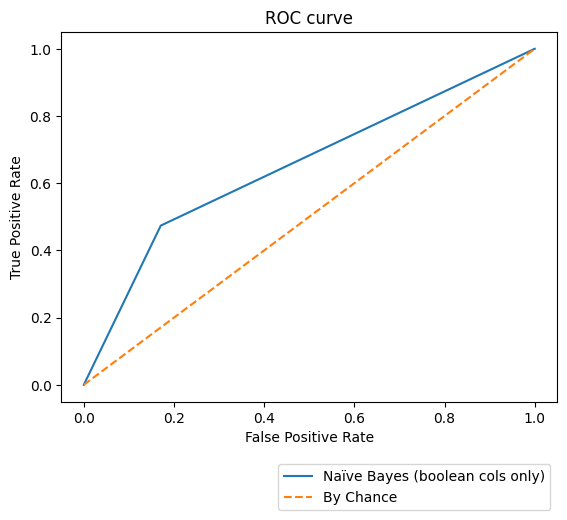

In [23]:
auc = make_ROC_curve(naive_test_predictions, naive_test_answers, "Naïve Bayes (boolean cols only)")

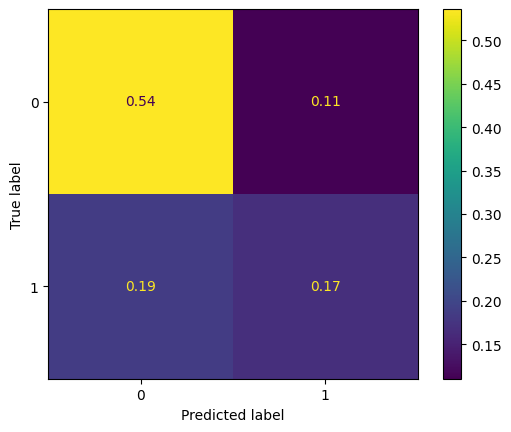

In [24]:
make_confusion_matrix(naive_test_predictions, naive_test_answers)

Our total proportion of correct predictions is (true positives) + (true negatives) ~ 0.70, and our AUC is ~0.65, so not great. But we expected that. Let's use the **variance inflation factor** to find the multicollinear columns, get rid of the ones that are too multicollinear, and see what happens when we redo classical Naïve Bayes.

Since we want to avoid **data leakage**, we'll be recalculating the VIF for each K-fold and removing columns with a VIF above 5. We don't want to be making decisions about which columns to remove based on data we'll be testing on.

Let's now redo classical Naïve Bayes only while removing the multicollinear columns.

In [25]:
multicol_removed_results, multicol_removed_answers, multicol_removed_predictions = k_fold_train_test_model(data,
                                            which_model = "naive_bayes",
                                            general_params_dict = remove_multicollinear_general_params_dict,
                                            naive_params_dict = classical_only_naive_params_dict)

Area under ROC curve (AUC): 0.6503249213747111


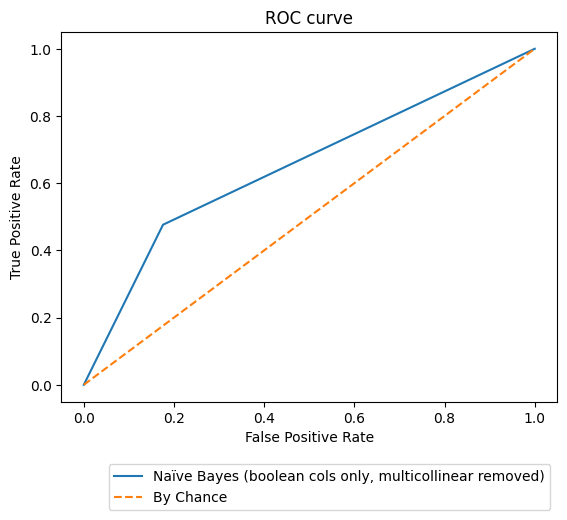

In [26]:
auc = make_ROC_curve(multicol_removed_predictions, multicol_removed_answers, "Naïve Bayes (boolean cols only, multicollinear removed)")

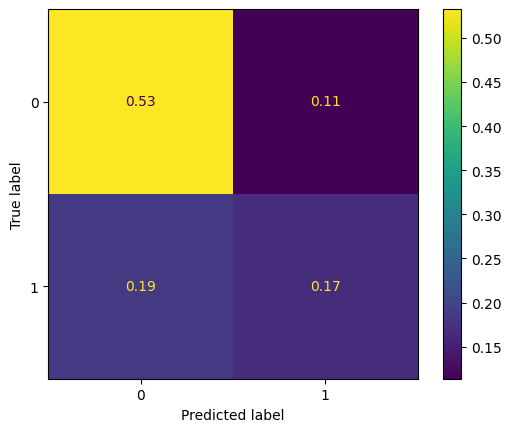

In [27]:
make_confusion_matrix(multicol_removed_predictions, multicol_removed_answers)

Okay, that didn't help. I'm not that surprised. With the way Naïve Bayes works, if we have columns that are highly multicollinear, we're almost multiplying by the same probabilities twice, so something previously classified as True is not suddenly going to have the False probability be higher after removing some columns. Let's look at Gaussian Naïve Bayes now.

## Gaussian and Classical Naïve Bayes

### Fitting Gaussians to the Uniform Distributions

As mentioned earlier, there are a few things we can do with our uniform distributions. The first is to just fit Gaussians to the data as-is. I don't expect this to go great, but I think it'll still do better than the classical Naive Bayes alone. Let's start by doing a version with both Gaussian and classical Naive Bayes, where we keep the multicollinear columns.

In [28]:
gaussian_results, gaussian_answers, gaussian_predictions = k_fold_train_test_model(data,
                                            which_model = "naive_bayes",
                                            general_params_dict = keep_multicollinear_general_params_dict,
                                            naive_params_dict = classical_and_gaussian_naive_params_dict)

Area under ROC curve (AUC): 0.727780777537797


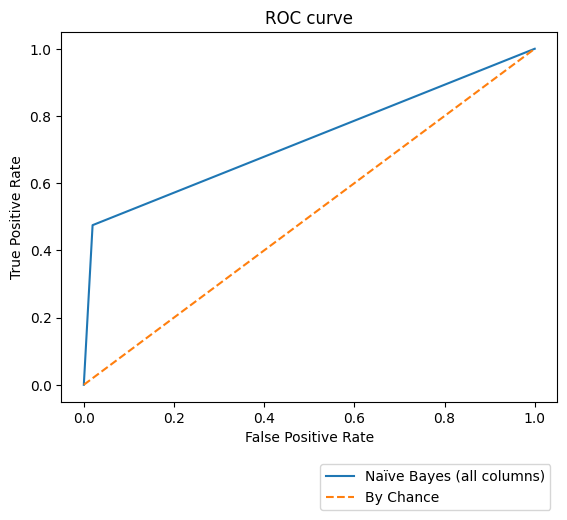

In [29]:
auc = make_ROC_curve(gaussian_predictions, gaussian_answers, "Naïve Bayes (all columns)")

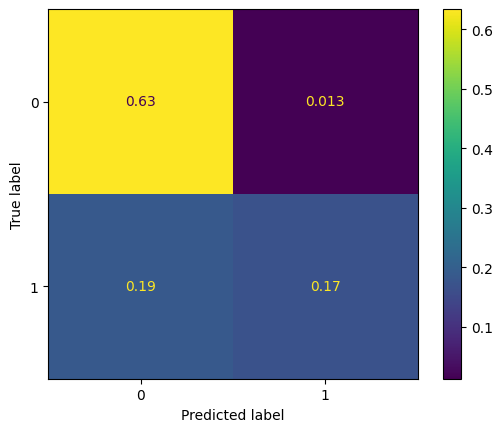

In [30]:
make_confusion_matrix(gaussian_predictions, gaussian_answers)

And now we try with removing the multicollinear columns. I don't expect to see any improvement here compared to the version with the multilcollinear columns.

In [31]:
gaussian_multicol_removed_results, gaussian_multicol_removed_answers, gaussian_multicol_predictions = k_fold_train_test_model(data,
                                            which_model = "naive_bayes",
                                            general_params_dict = remove_multicollinear_general_params_dict,
                                            naive_params_dict = classical_and_gaussian_naive_params_dict)

Area under ROC curve (AUC): 0.7243672085180554


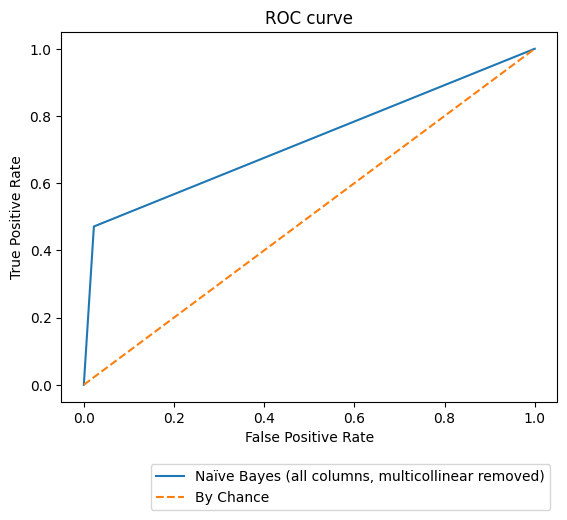

In [32]:
auc = make_ROC_curve(gaussian_multicol_predictions, gaussian_multicol_removed_answers, "Naïve Bayes (all columns, multicollinear removed)")

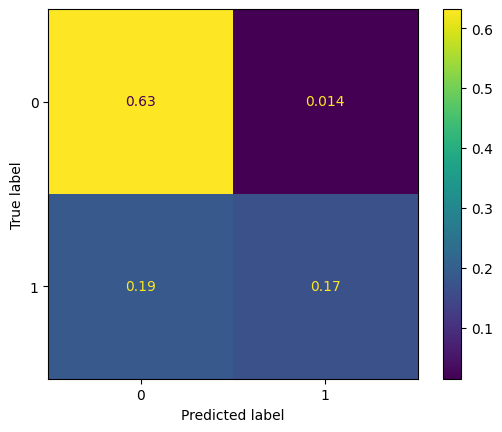

In [33]:
make_confusion_matrix(gaussian_multicol_predictions, gaussian_multicol_removed_answers)

We can see that even when fitting Gaussians to uniform distributions, we do see a good amount of improvement compared to the case where we didn't consider the continuous data at all. Our AUC increased by ~0.07, or 11%, which is really good. Our accuracy also increased from ~0.7 to 0.8, or a 14% increase, which is not something to scoff at. This is somewhat expected, since we'd still expect to see different means for the features which are very correlated with the label, leading to different probability density functions and likelihood estimations.

### Transforming Uniform to Normal Distributions

The next thing we can try is transforming our distributions to be normal. Since our original continuous data distributions are mostly uniform, there are a few ways to do this transformation. One is the **Box-Muller transform**. Normally, this transform takes 2 independent uniform distributions and creates 2 independent normal distributions from them, but I've adapted it to just take 1 uniform distribution and spit out a (maybe) normal distribution. It seems a bit finnicky.

We can see that AlcoholConsumption after the Box-Muller transform seems to look better, if still missing the tails, but CholesterolTriglycerides looks very silly after the transform. I did try shifting the data left to start at 0 (since many of the clinical measurement have some minimum cutoff), and while that helped in some cases, other cases still have very clearly non-normal distributions.

In [34]:
def box_muller_transform(data_col: pd.Series, to_subtract: float=0.0) -> pd.Series:
    R = 2*np.log(data_col - to_subtract)
    theta = 2*np.pi*(data_col - to_subtract)
    
    x = R * np.sin(theta)
    return x

<Axes: >

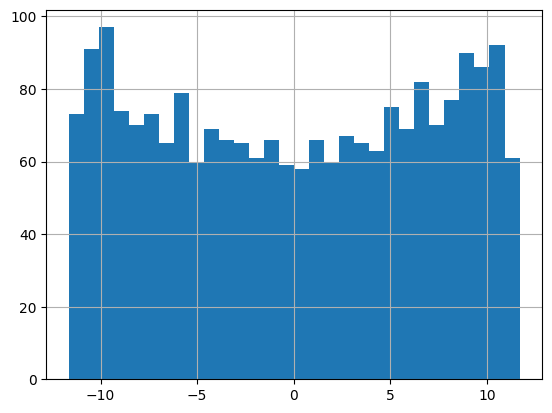

In [35]:
transformed_choltotal = box_muller_transform(data["CholesterolTriglycerides"], 50)
transformed_choltotal.hist(bins=30)

<Axes: >

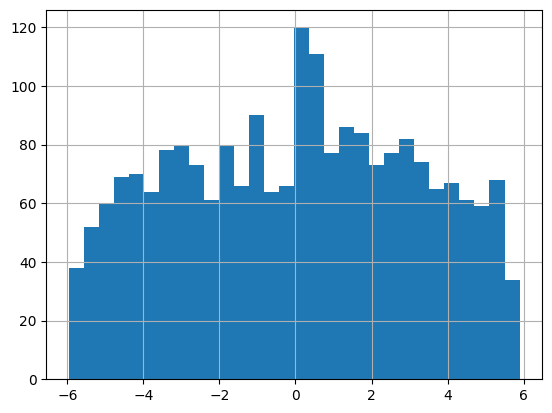

In [36]:
transformed_alcohol = box_muller_transform(data["AlcoholConsumption"], 0)
transformed_alcohol.hist(bins=30)

Clearly, this transform isn't going so great (probably because I'm not using it as intended), so let's try a scikit function specifically meant for this: Quantile Transform.

The [**Quantile Transformer**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) class provides us with ways to save the transformation parameters so we can reuse them on the testing data. One thing to keep in mind is that this is a non-linear transformation that _will_ distort relations in the data, and it's really not ideal to be taking a subsection of a normal distribution with the tails chopped off and then transforming it into a different normal distribution that does have tails. It's very messy.

Still, it's worth a try to see if it improves our results. Let's define our columns to quantile transform and see what our transformed data looks like.

array([[<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'SleepQuality'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'CholesterolHDL'}>],
       [<Axes: title={'center': 'DiastolicBP'}>,
        <Axes: title={'center': 'DietQuality'}>,
        <Axes: title={'center': 'FunctionalAssessment'}>,
        <Axes: title={'center': 'CholesterolTotal'}>],
       [<Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'SystolicBP'}>,
        <Axes: title={'center': 'CholesterolTriglycerides'}>,
        <Axes: title={'center': 'PhysicalActivity'}>],
       [<Axes: title={'center': 'ADL'}>,
        <Axes: title={'center': 'CholesterolLDL'}>,
        <Axes: title={'center': 'AlcoholConsumption'}>, <Axes: >]],
      dtype=object)

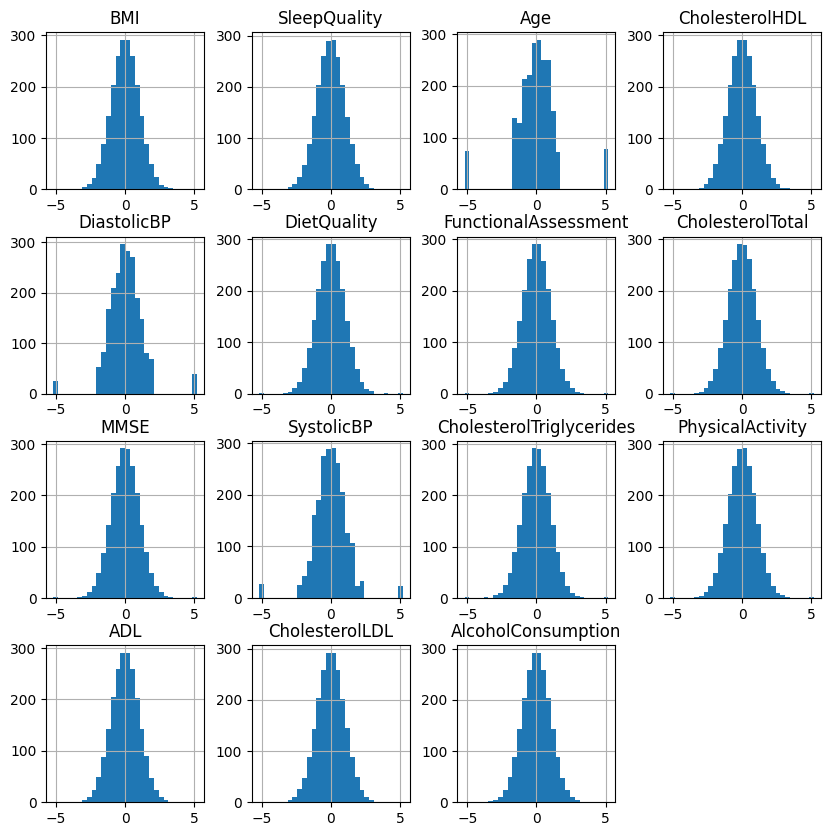

In [37]:
# Education level is already bell-curve-shaped, so we're going to leave it alone.
# All the other continuous features need transforming to normal.
columns_to_quantile_transform = data.dtypes[data.dtypes != bool].index.tolist()
columns_to_quantile_transform.remove("EducationLevel")

q = QuantileTransformer(output_distribution="normal", n_quantiles=1000)
transformed_data = pd.DataFrame(q.fit_transform(data[columns_to_quantile_transform]), columns=columns_to_quantile_transform)
transformed_data.hist(figsize=(10,10), bins=30)

That is truly magical and frankly a little unsettling. In the original plots, the distributions looked noticeably different for certain features, Now they all look almost identical besides a few. So odd. It's also quite odd that some of them (like age) have some far-out outlier bins and empty space between those outlier bins and the main middle bit. It's very odd and not a normal distribution, and to me just seems to show that trying to force this feature to be normal is a bad idea.

One inaccuracy with using the transformation like this is that we're transforming each whole feature column into a single normal distribution, regardless of label value. Really, what we want is one normal distribution for Diagnosis true and one for Diagnosis false, and theoretically, there is nothing from stopping the ideal transformation from looking like below:

By assuming that all the values in a feature column comprise one nice, neat distribution rather than different distributions based on label value, we're assuming that the distributions corresponding to Diagnosis true and false fall into the left paradigm of the plot below, rather than the paradigm on the right, or something even more spread out.

<img src="https://www.researchgate.net/profile/Sascha-Spors/publication/224137690/figure/fig6/AS:652214334918658@1532511423479/Sum-of-Gaussian-distributions.png">

[Image source](https://www.researchgate.net/figure/Sum-of-Gaussian-distributions_fig6_224137690)

It's a dangerous and possibly wrong assumption, which is why I think it's important to see if the features' original uniform distributions corresponding to each label value have significant overlap. In this case, they do due to the artificial cutoffs, but it also means that Gaussian Bayes possibly won't help us predict the label much better. Guassian Bayes makes the most different when your distributions have noticeably different means, which is exactly the opposite of what the quantile transform does.

However, it should be VERY clear why we can't do two transformations, one for Diagnosis true and one for Diagnosis false. Which one of those transformations would you then use on any new test data you want to predict on? Avoiding **data leakage** and thinking ahead to how you'll handle testing data is always paramount. I've spoken more on the dangers of data leakage in my Housing Prices notebook.

Let's see what the results look like when K-fold cross-validating. The quantile transformer will be fit to the training data, and that fit will be used to transform both the training and testing data (so we're not fitting to testing data).

In [38]:
quantile_transform_naive_params_dict = classical_and_gaussian_naive_params_dict.copy()
quantile_transform_naive_params_dict["do_quantile_transform"] = True
quantile_transform_naive_params_dict["columns_to_quantile_transform"] = columns_to_quantile_transform

quantile_dict, quantile_answers, quantile_predictions = k_fold_train_test_model(data,
                                            which_model = "naive_bayes",
                                            general_params_dict = keep_multicollinear_general_params_dict,
                                            naive_params_dict = quantile_transform_naive_params_dict)

Area under ROC curve (AUC): 0.7043201280739646


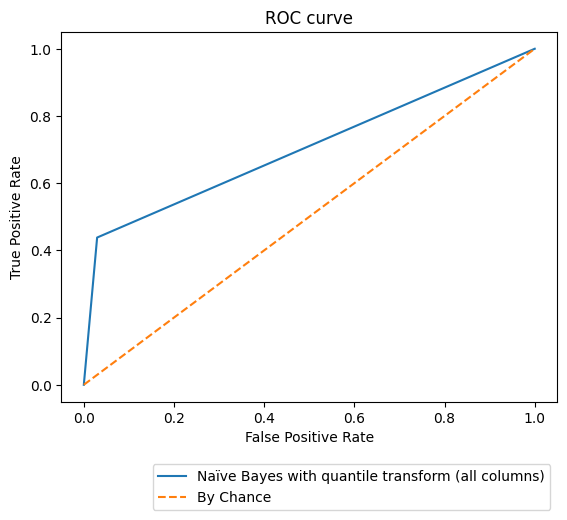

In [39]:
auc = make_ROC_curve(quantile_predictions, quantile_answers, "Naïve Bayes with quantile transform (all columns)")

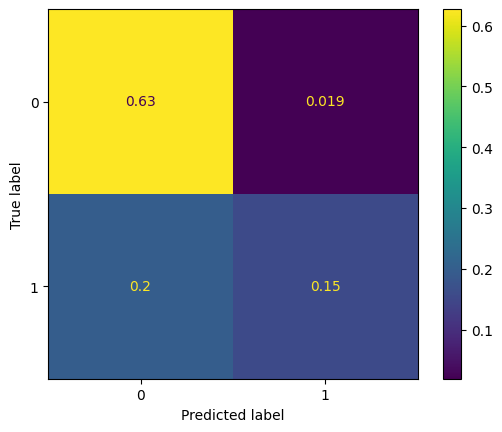

In [40]:
make_confusion_matrix(quantile_predictions, quantile_answers)

And let's see what it looks like when we remove multicollinear columns.

In [41]:
test_results_dict, all_test_answers, all_test_predictions = k_fold_train_test_model(data,
                                            which_model = "naive_bayes",
                                            general_params_dict = remove_multicollinear_general_params_dict,
                                            naive_params_dict = quantile_transform_naive_params_dict)

Area under ROC curve (AUC): 0.6999010079193665


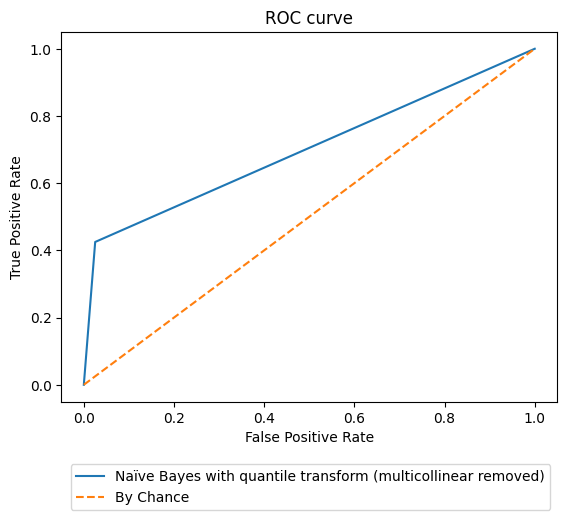

In [42]:
auc = make_ROC_curve(all_test_predictions, all_test_answers, "Naïve Bayes with quantile transform (multicollinear removed)")

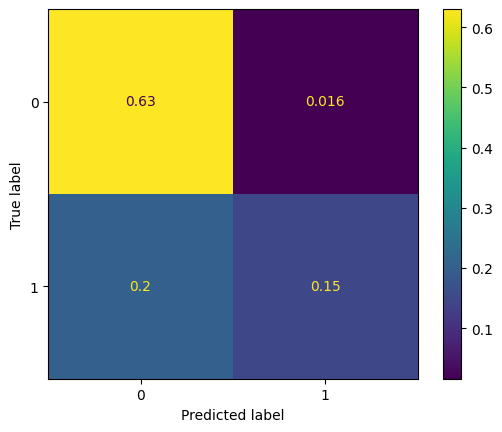

In [43]:
make_confusion_matrix(all_test_predictions, all_test_answers)

So transforming the uniform-ish distributions to normal actually made the results a tiny bit worse than if we'd just left them alone. I'd assume it's because the data in its original form is already Gaussian (although with the tails chopped off), and by distorting the data with non-linear transformations, we're breaking the original relations in the data. We're turning the data into something very different than it was when it was already in the correct form to start with. That's interesting to know!

And we've confirmed that in the case of Naive Bayes, removing multicollinear columns doesn't really help with accuracy, although it can reduce computation time and resource requirements if we're removing a significant number of columns. Let's move on to the next method of classification.

# Logistic Regression

**Logistic regression** is for binary classification tasks, and can be extended to multiple classes via multinomial logistic regresson. We have a binary classification problem here, so we'll stick with logistic regression.

Note that logistic regression has a different purpose from **linear regression** tasks, which predict a continuous variable rather than a class. However, logistic regression does derive from the same principles, and is actually just a transformation of linear regression. To do logistic regression, we apply a **sigmoid function** to the output of the linear regression model. Since the sigmoid function goes from 0 to 1, we've essentially turned the linear regression outputs into probabilities. This can also be understood as setting the odds (i.e. $P/(1-P)$) to the linear regression equation $m_1x_1 + m_2x_2 + ... + m_nx_n + b_0$ and then deriving the probability $P$ from there.

Because of this transformation, we cannot use the **least squared errors (LSE)** loss function commonly used for linear regression; we instead need to use **logistic loss**, also known as **cross-entropy loss**. However, we can still use the same optimization algorithm usually used to decrease the loss function the optimization algorithm stays the same, which is **gradient descent**, done with **backwards propagation**. While there are other possible optimization algorithms (e.g. Newton's method), gradient descent still remains by far the most popular method.

Logistic regression does require that there is no categorical data, which is already the case here, so we're all good to jump straight into implementing logistic regression.

## Regularization

Regularization is a method of avoiding overfitting when using regression models. (I've talked more about over- and underfitting in a [previous notebook](https://www.kaggle.com/code/avilashahaldar/housing-prices-with-gradient-boosting-trees).) Regularization involves potentially increasing training error (i.e. increasing **bias**) for the sake of significantly reducing errors when predicting new data (i.e. decreasing **variance**). High bias is a term used to describe when a model is underfitting, while high variance describes overfitting. Ideally, we want a balance between these, and since regression models can easily overfit if we're not careful or if we don't have a lot of training data, we introduce ways of avoiding overfitting like regularization.

**Ridge regression**, also called **L2 regularization**, is a form of regularization which penalizes large coefficients by adding an **L2 penalty term** to the loss function in a regression model. This penalty term acts upon the squares of coefficients, but doesn't set coefficients to 0.

**Lasso regression**, or **L1 regularization**, adds an **L1 penalty term** that is otherwise the same as L2, but acts on the absolute values of coefficients and can set coefficients to 0. Due to this, L1 is better for filtering out multicollinearity.

Both L1 and L2 regularization have their benefits and drawbacks, which was why **elastic net regularization** was formulated to combine these two and maintain the best aspects of both. In all three cases, the strength of penalization is determined through the parameter $\lambda$ (or sometimes $\alpha$). When this is set to 0, the penalization term is always 0, so we get the equivalent of no regularization at all. The higher $\lambda$ is, the greater the penalization.

Because scikit recommends the liblinear solver for smaller datasets, and this only allows L1 and L2 regression (not elastic net, and no "None" option either), I'll be trying this solver with L1 and L2 regression. I did also think of trying the saga solver with all 4 allowed regularization options (L1, L2, elastic net, and None), but that doesn't converge in the max_iterations, so I decided to abandon that. **Convergence** means we've reached a stable solution across iterations, and we don't really want to pick a model that doesn't converge.

Many machine learning methods prefer data to be scaled to between 0 and 1, namely those that use backpropagation, since those tend to do better when the coefficients are small. This is because it's easier for the model to find a nice valley in the error function if it's already close to there to begin with, and the randomly initialized values tend to not be very big. Thus, we're going to be scaling our continuous data according to the data description and using that for these next few methods. This is just simple linear scaling - if we're considering e.g. the SystolicBP column, which goes from 90 to 180, we just subtract 90 to make the range 0 to 90, and then divide by 90. Nothing crazy.

In [44]:
l1_params_dict = default_log_regress_params_dict.copy()
l1_params_dict["loss_func"] = "l1"

l2_params_dict = default_log_regress_params_dict.copy()
l2_params_dict["loss_func"] = "l2"

scaled_data = scale_continuous_data(data.copy())

l1_liblin_test_results, l1_test_answers, l1_preds = k_fold_train_test_model(scaled_data,
                                            which_model = "logistic_regression",
                                            general_params_dict = keep_multicollinear_general_params_dict,
                                            logregress_params_dict = l1_params_dict)

l2_liblin_test_results, l2_test_answers, l2_preds = k_fold_train_test_model(scaled_data,
                                            which_model = "logistic_regression",
                                            general_params_dict = keep_multicollinear_general_params_dict,
                                            logregress_params_dict = l2_params_dict)

We'll look at the results for logistic regression later, once we've gotten some other results to compare.

# Support Vector Machines

These are fun. I like them because of how unique they are in that they don't consider most of the data; they consider the datapoints in each class that border datapoints of other classes and don't consider data deep in the middle of a group of same-class datapoints (I hesitate to use the term cluster in case this gets confused with K-means clustering, where the clusters are not defined beforehand). These edge datapoints are called **support vectors**, and are where support vector machines get their name.

**Support vector machines** (SVMs) figure out the optimal hyperplane for defining the margin, or the space between different classes. While the most basic version of an SVM will create linear hyperplanes, these are often not accurate, so instead we can project our data into even more dimensions to get curves which more accurately delineate our classes. This is called using a **kernel method**.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png" width=600>

[Image source](https://scikit-learn.org/stable/modules/svm.html)

Here's a 3D representation of what an SVM kernel method may do. It maps to higher dimensions not there in the original data so as to get a better separator.

<img src="https://images.squarespace-cdn.com/content/v1/60bf6a0ed36614062037a08b/1632584076683-AV0U98J857F1H7ULSQV5/kernel.001.png?format=1500w" width=600>

[Image source](https://www.hashpi.com/the-intuition-behind-kernel-methods)

## Principal Component Analysis

We're going to be trying a new technique here called **principal component analysis** (PCA) to turn our many-dimensional data into just a few dimensions. This can be useful when there are potentially less important features with less explanatory power that could lead to high variance as they are given undue importance. PCA works by first finding the best fit line through all the data, then the next best fit line that is perpendicular to the first, then the next best fit line that's perpendicular to the other two, etc. until you have as many lines as there are dimensions. (In our case, dimensions = number of features.) If we want, say, 2 components in our final PCA, we then rotate the data so that the first two best fit lines are the new x and y axes. Similarly, if we want 3 components in our final PCA, we rotate the data so the three top best fit lines are the new axes, taking us down from (number of features) dimensions (which is something like ~35 for the Alzheimer's data) down to 3.

As always, we will fit our PCA on the training data in each K-fold and then use that same fit to transform the testing data. We do NOT fit the PCA on the testing data.

I'll be running 2 versions of the SVM - one with 7-component PCA (I chose this arbitrarily, mostly because lower numbers of components gave me terrible results), and one that doesn't use PCA at all.

In [45]:
pca_general_params_dict = keep_multicollinear_general_params_dict.copy()
pca_general_params_dict["do_PCA"] = True
pca_general_params_dict["num_PCA_components"] = 7

this_svm_params_dict = {"C": 5.0,
                       "kernel": "poly",
                       "degree": 2,
                       "gamma": "auto",
                       "coef0": 1.0,
                       "max_iter": 500000}

svm_test_results, svm_answers, svm_preds = k_fold_train_test_model(scaled_data,
                                            which_model = "svm",
                                            general_params_dict = keep_multicollinear_general_params_dict,
                                            svm_params_dict = this_svm_params_dict)

svm_pca_test_results, svm_pca_answers, svm_pca_preds = k_fold_train_test_model(scaled_data,
                                            which_model = "svm",
                                            general_params_dict = pca_general_params_dict,
                                            svm_params_dict = this_svm_params_dict)

Let's now compare the two regularization methods for logistic regression, our support vector machine, as well as our Naive Bayes including all columns and no quantile transformation, and no removal of multicollinear columns, as this was one of the best-performing Naive Bayes versions.

In [46]:
results_df = pd.concat([l1_liblin_test_results, l2_liblin_test_results, gaussian_results, svm_test_results, svm_pca_test_results], axis=1)
results_df.columns = ["L1 LogRegress", "L2 LogRegress", "Naive Bayes", "SVM", "SVM with PCA"]
results_df = results_df / results_df.sum(axis=0)

results_df.loc["Accuracy"] = results_df.loc["TP"] + results_df.loc["TN"]
results_df.loc["Precision"] = results_df.loc["TP"] / (results_df.loc["TP"] + results_df.loc["FP"])
results_df.loc["Recall"] = results_df.loc["TP"] / (results_df.loc["TP"] + results_df.loc["FN"])

results_df.loc["AUC"] = [roc_auc_score(l1_test_answers, l1_preds),
                      roc_auc_score(l2_test_answers, l2_preds),
                      roc_auc_score(gaussian_answers, gaussian_predictions),
                      roc_auc_score(svm_answers, svm_preds),
                      roc_auc_score(svm_pca_answers, svm_pca_preds)]

In [47]:
results_df

,L1 LogRegress,L2 LogRegress,Naive Bayes,SVM,SVM with PCA
TP,0.274419,0.297674,0.167985,0.237209,0.120930
TN,0.562791,0.544186,0.633783,0.618605,0.520930
FP,0.074419,0.065116,0.012564,0.060465,0.060465
FN,0.088372,0.093023,0.185668,0.083721,0.297674
Accuracy,0.837209,0.841860,0.801768,0.855814,0.641860
Precision,0.786667,0.820513,0.930412,0.796875,0.666667
Recall,0.756410,0.761905,0.475000,0.739130,0.288889
AUC,0.815394,0.812774,0.727781,0.813482,0.607449


Text(0.5, 1.0, "Alzheimer's Data: Comparing Analysis Methods")

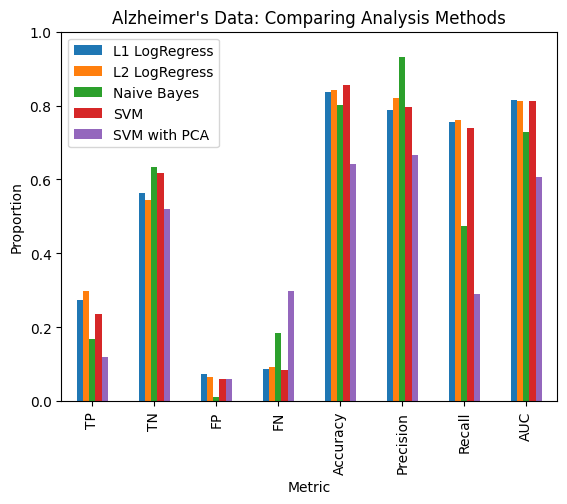

In [48]:
results_df.plot.bar()
plt.xlabel("Metric")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.title("Alzheimer's Data: Comparing Analysis Methods")

Here, we've plotted the accuracy, precision, and recall of all of our methods. Let's quickly talk about some of these new metrics:

- **Accuracy** tells us what proportion of all predictions are correct, so (true positive + true negatives) / all predictions. This is good when the classes are balanced, but in the case of imbalanced classes like we have, can lead to a poor idea of how well we predict the class we're actually interested in.
    - Consider the case when 95% of label values are negatives, and 5% are positive. If our model simply outputs "negative" 100% of the time, it has an accuracy of 95%, but this is obviously a silly and useless model. Therefore, accuracy doesn't work well when classes are highly imbalanced.
- **Precision** tells us how many of our positive predictions are correct, so (true positives) / (true positives + false positives). It's most useful to consider when false positives are very costly and we want to be absolutely confident in any positive predictions we make, such as with a spam filter. This isn't necessarily the case for medical diagnoses though, where a false positive may lead to needing extra tests to truly confirm a diagnosis, whereas a false negative can lead to hospitalization, disability, or even death if a condition is missed.
- **Recall** tells us how many of the actual positive values we correctly labelled positive, so (true positives) / (true positives + false negatives), and should be maximized when false negatives are very costly. In the medical field, this is termed **sensitivity**, and is probably what we care most about here.

The metrics that are most useful to consider will depend on the problem you're trying to solve. Personally, I'd focus on recall in this case, which means that L1 is slightly better than L2 logistic regression, and tells us for sure that Naive Bayes is _not_ the way to go here. If precision were what we were after, then Naive Bayes would be best (which may be part of why Naive Bayes is so popular for spam filters), but for medical diagnoses, I'd err on the side of caution and prefer false positive to false negatives.

# Conclusions

I will admit, I'm taken by surprise by how the Naive Bayes accuracy doesn't actually fall too far below logistic regression, and has a higher precision. Earlier, I mentioned that I'd choose to skip over Naive Bayes entirely in a production setting because the tails were cut off the Gaussian features, but I suppose this is a lesson for me to not be so quick to discount the power of relatively simple ML methods.

I can also clearly tell that PCA was _not_ the right decision here. It looks like we're missing vital relations between features, since our SVM with PCA does significantly worse than the original SVM in every metric. With the SVM, it would be worth trying lots of other configurations as well -- different kernels, different degrees for the polynomial solver, etc.

Overall, the SVM and L2 logistic regression look to do the best and are very comparable in results. It would definitely be worth trying other SVM configurations (kernels, polynomial degrees, etc.) to see if any of the other kernels do better.

I hope you were able to learn a bit from this notebook about different classification methods. Have a great day!